In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus
import pyranges as pr
import upsetplot

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.vcf_utils import *
from scripts.plotting import *

In [2]:
config = load_config()
od = '../../snakemake/compare_external/'

In [3]:
df = pd.DataFrame()
ics = [od+config['gtex']['cerb']['ics'],
       od+config['chess']['cerb']['ics'],
       od+config['enc']['cerb']['ics'],
       od+config['lr']['cerb']['ics'],
       od+config['ref']['cerb']['ics']]
sources = ['GTEx', 'CHESS3', 'ENCODE4', 'PODER', 'GENCODE v47']
for ic, source in zip(ics, sources):
    temp = pd.read_csv(ic, sep='\t')
    
    # remove monoexonic, add source, drop name
    temp = temp.loc[temp.Coordinates != '-']
    temp['source'] = source
    temp = temp.drop('Name', axis=1)
    
    df = pd.concat([df, temp], axis=0)    

In [4]:
temp = df.copy(deep=True)

In [5]:
df = df.pivot_table(
    index=['Strand', 'Coordinates', 'Chromosome'],
    columns='source',
    aggfunc=lambda x: True,
    fill_value=False).reset_index()
# df.columns = ['_'.join(col).strip() if col[1] else col[0] for col in df.columns.values]
df.head()
df.reset_index(drop=True, inplace=True)

In [6]:
# df.loc[(df.chess==True)&(df.gtex==True)].Coordinates.tolist()[0]


In [7]:
temp.loc[temp.Coordinates=='100015726-100019230-100019349-100023418-100023932-100024153-100024307-100029860-100029952-100030248-100030375-100033304']

,Chromosome,Strand,Coordinates,source
81964,chr7,+,100015726-100019230-100019349-100023418-100023...,GTEx
122967,chr7,+,100015726-100019230-100019349-100023418-100023...,CHESS3


In [8]:
df.head()

source,Strand,Coordinates,Chromosome,CHESS3,ENCODE4,GENCODE v47,GTEx,PODER
0,+,100000063-100008120-100008322-100011375,chr7,False,False,True,False,False
1,+,100006296-100007901-100008231-100037527,chr4,False,False,True,False,False
2,+,1000064-1000611-1000697-1000881-1000989-100146...,chr4,True,False,True,False,True
3,+,100008231-100024938-100025080-100025281-100025...,chr4,False,False,True,False,False
4,+,100015726-100019230-100019349-100023418-100023...,chr7,True,True,True,False,False


In [9]:
# df['id'] = df.Strand+'_'+df.Chromosome+'_'+df.Coordinates
# df.drop(['Strand', 'Chromosome', 'Coordinates'], axis=1, inplace=True)
# df = df.groupby(['chess', 'gtex']).count().rename({'id':'n_ics'}, axis=1)

In [10]:
df.set_index(sources, inplace=True)

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>}

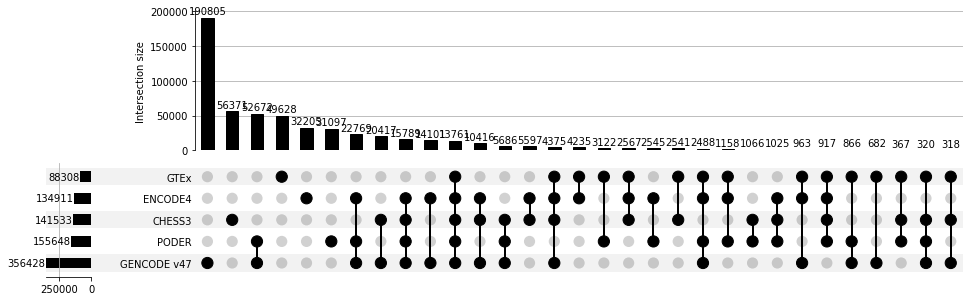

In [11]:
upsetplot.plot(df, sort_by='cardinality', show_counts=True)


## What about the % of novel transcripts per de novo annotation that are supported by the other annotations?

In [112]:
df  = df.reset_index()
df.head()

source,index,GTEx,CHESS3,ENCODE4,PODER,GENCODE v47,Strand,Coordinates,Chromosome
0,0,False,False,False,False,True,+,100000063-100008120-100008322-100011375,chr7
1,1,False,False,False,False,True,+,100006296-100007901-100008231-100037527,chr4
2,2,False,True,False,True,True,+,1000064-1000611-1000697-1000881-1000989-100146...,chr4
3,3,False,False,False,False,True,+,100008231-100024938-100025080-100025281-100025...,chr4
4,4,False,True,True,False,True,+,100015726-100019230-100019349-100023418-100023...,chr7


In [114]:
novel_sources = [s for s in sources if s != 'GENCODE v47']
perc_df = pd.DataFrame()
for s in novel_sources:
    
    # get novel transcripts from this annotation
    temp = df.loc[(df[s] == True)&(df['GENCODE v47']==False)].copy(deep=True)
    
    other_nov_sources = [ns for ns in novel_sources if ns != s]
    temp['supported_by_external'] = (df[other_nov_sources].sum(axis=1))>0
    temp = temp[['supported_by_external', 'Coordinates']]

    temp = temp.groupby('supported_by_external').count().reset_index().rename({'Coordinates':'n_ic'}, axis=1)
    temp['dataset'] = s
    temp['total'] = temp['n_ic'].sum(axis=0)
    temp['perc'] = (temp['n_ic']/temp['total'])*100
    
    temp = temp.loc[temp.supported_by_external==True]
    temp = temp[['dataset', 'perc', 'n_ic']]
    perc_df = pd.concat([perc_df, temp], axis=0)

In [116]:
perc_df

source,dataset,perc,n_ic
1,GTEx,23.099094,14907
1,CHESS3,19.985522,14080
1,ENCODE4,35.909172,18044
1,PODER,24.699131,10200


In [141]:
def add_perc_2(ax, df):
    ylim = ax.get_ylim()[1]
    n_cats = len(ax.patches)
    for p in ax.patches:
        h = p.get_height()
        tot = df.loc[df.n_ic==h, 'perc'].values[0]
        x = p.get_x() + p.get_width() / 2 - (0.09)*n_cats
        y = p.get_y() + p.get_height() + ylim*0.01
        ax.annotate(f'{tot:.2f}%', (x, y), size = 18)

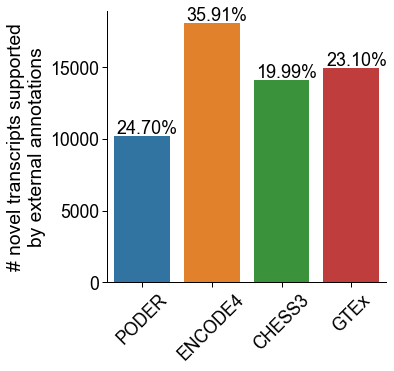

In [142]:
init_plot_settings(aspect='square')
ax = sns.barplot(perc_df, y='n_ic', 
                 x='dataset', order=['PODER', 'ENCODE4', 'CHESS3', 'GTEx'])
add_perc_2(ax, perc_df)
ax.set(ylabel='# novel transcripts supported\nby external annotations',xlabel='')
clean_figure(ax)

## Now look at support w/ at least one other external annotation by novelty category

In [18]:
df.reset_index(inplace=True)
df = df.loc[df.PODER==True]

In [27]:
# get ics again from poder, oops
od = '../../'

def proc_cfg(entry, od):
    entry = entry.replace('../../', '')
    entry = od+entry
    return entry

gtf_file = proc_cfg(config['lr']['gtf_filt_with_genes'], od)
gtf_df = pr.read_gtf(gtf_file, duplicate_attr=True)

In [25]:
gtf_df = cerberus.get_ic(gtf_df)

In [29]:
gtf_df.rename({'ic':'Coordinates'}, axis=1, inplace=True)
gtf_df.head()

,Chromosome,Strand,transcript_id,gene_id,Coordinates
0,GL000008.2,-,transcript_190114,ENSG00000296775.1,170271-163998-163784-162439
1,GL000008.2,-,transcript_190115,ENSG00000296775.1,170271-164884-164584-163998-163784-162439
2,GL000008.2,-,transcript_190116,ENSG00000296775.1,170271-164884-164602-157581
3,GL000008.2,-,transcript_190117,ENSG00000296775.1,170271-164884-164602-163998-163784-157581
4,GL000008.2,-,transcript_190118,ENSG00000296775.1,170271-164884-164602-163998-163784-162439


In [30]:
df = df.merge(gtf_df.drop('gene_id', axis=1),
              how='left',
              on=['Chromosome', 'Coordinates', 'Strand'])

In [33]:
assert len(df.loc[df.transcript_id.isnull()]) == 0

In [35]:
# get novelty cats from the mt
mt_df = pd.read_csv('../../data/05_mastertable/master_table.tsv', sep='\t')
mt_df = mt_df.loc[mt_df['filter']=='pass']
mt_df['pop_spec_t'] = (mt_df.population_sharing==1)&\
                      (mt_df.sample_sharing>1)
df = df.merge(mt_df[['structural_category', 'isoform']],
              how='left',
              left_on='transcript_id',
              right_on='isoform')

In [38]:
# make sure our missing things are always ENST
assert len(df.loc[(df.isoform.isnull())]) == len(df.loc[df.transcript_id.str.startswith('ENST')])

# then fill na struct cat w/ FSM
df.loc[df.isoform.isnull(), 'structural_category'] = 'FSM'

In [42]:
df['supported_by_external'] = (df[['GTEx', 'CHESS3', 'ENCODE4']].sum(axis=1))>0

In [47]:
temp = df[['transcript_id', 'structural_category', 'supported_by_external']].groupby(['structural_category', 'supported_by_external']).count().reset_index().rename({'transcript_id':'n_t'},axis=1)

In [48]:
temp.head()

,structural_category,supported_by_external,n_t
0,Antisense,False,948
1,Antisense,True,54
2,FSM,False,52676
3,FSM,True,61902
4,Fusion,False,914


In [55]:
def clean_figure(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(axis="x", rotation=45)

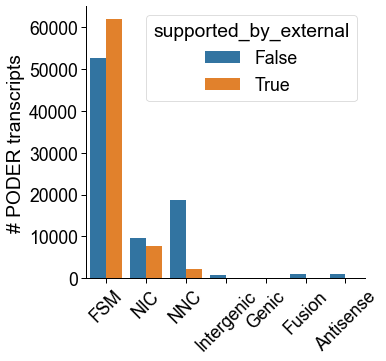

In [56]:
init_plot_settings(aspect='square')
c_dict, order = get_novelty_colors(temp['structural_category'].unique().tolist())
ax = sns.barplot(temp, x='structural_category', hue='supported_by_external', 
            y='n_t', order=order)
ylabel = '# PODER transcripts'
ax.set(ylabel=ylabel, xlabel='')
clean_figure(ax)